<a href="https://colab.research.google.com/github/NxrFesdac/bourbaki-nlp-avanzado/blob/main/modulo3/Glove_Train_Vs_Wikipedia_Glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install numpy scikit-learn matplotlib gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 38.0 MB/s eta 0:00:00


Loading corpus: text8 (first 30000 sentences)
[==================================================] 100.0% 31.6/31.6MB downloaded
Vocab size: 10000
Vocab example: ['the', 'of', 'and', 'one', 'in', 'a', 'to', 'zero', 'nine', 'two', 'is', 'as', 'eight', 'for', 's', 'five', 'three', 'was', 'by', 'that']
Co-occurrence pairs: 12806546

Training GloVe (SGD)...
epoch 01 | avg loss 0.1910
epoch 02 | avg loss 0.1448
epoch 03 | avg loss 0.1319
epoch 04 | avg loss 0.1263
epoch 05 | avg loss 0.1232
epoch 06 | avg loss 0.1214
epoch 07 | avg loss 0.1202
epoch 08 | avg loss 0.1194

Loading pretrained: glove-wiki-gigaword-100
[==================================================] 100.0% 128.1/128.1MB downloaded
Pretrained vocab size: 400000
Shared anchor words: 5000

Word: king

Wikipedia GloVe neighbors:
  prince          0.768
  queen           0.751
  son             0.702
  brother         0.699
  monarch         0.698
  throne          0.692
  kingdom         0.681
  father          0.680

Trained G

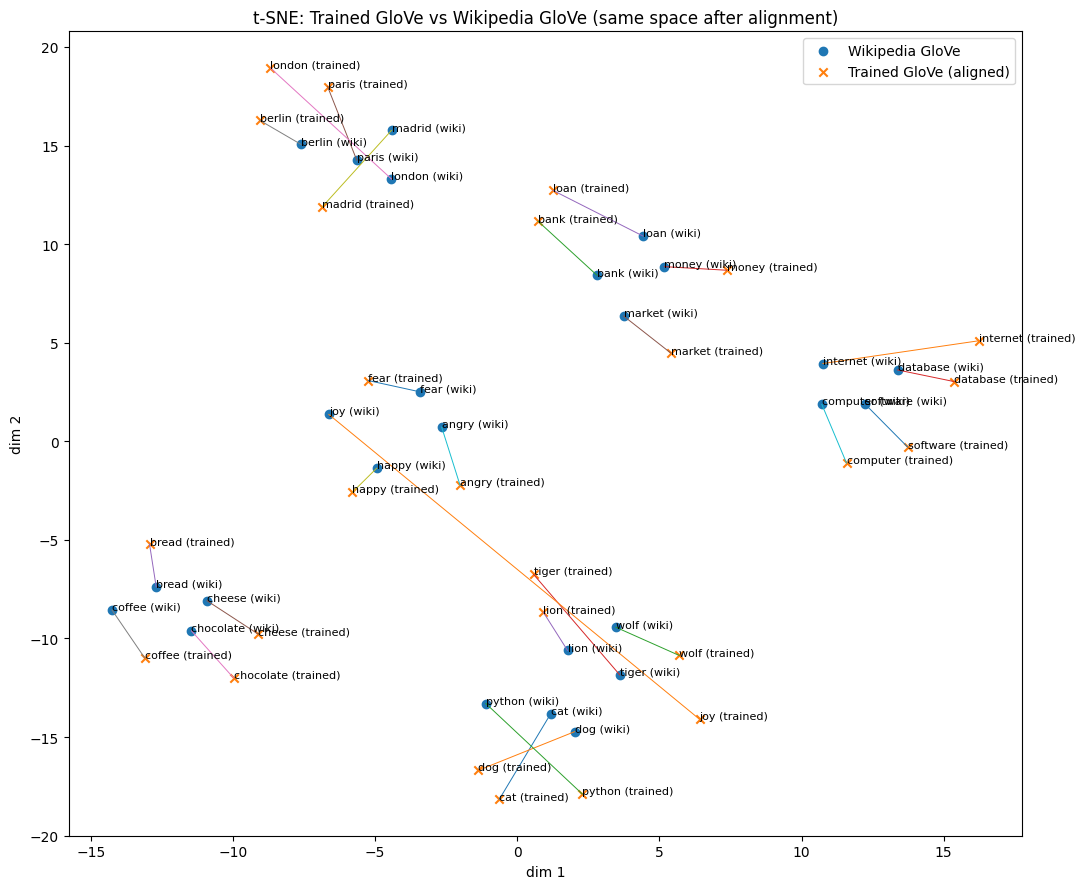

In [ ]:
# -*- coding: utf-8 -*-
"""
Train a *GloVe* model (like your glove_training.py) and compare it vs
Wikipedia/Gigaword pretrained GloVe in ONE shared vector space + t-SNE plot.

This is intentionally simple / "notebook style" like your provided code.

Tip (Colab):
    Uncomment the pip install line if you need it.
"""

# If you need installs in the notebook, uncomment:
# !pip -q install numpy scikit-learn matplotlib gensim

import math
import random
import numpy as np
from collections import defaultdict, Counter
from itertools import islice

import gensim.downloader as api
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# 1) Load a small Wikipedia-like corpus (text8)
# ------------------------------------------------------------
# Increase these if you want better quality (but it will be slower).
N_SENTENCES = 30_000      # how many "sentences" to read from text8
MAX_VOCAB   = 10_000      # keep only the most frequent words
MIN_COUNT   = 5           # ignore very rare words

print("Loading corpus: text8 (first", N_SENTENCES, "sentences)")
raw_sentences = list(islice(api.load("text8"), N_SENTENCES))

# Build vocab by frequency (simple + fast)
counts = Counter()
for s in raw_sentences:
    counts.update(s)

vocab = [w for (w, c) in counts.most_common(MAX_VOCAB) if c >= MIN_COUNT]
stoi  = {w: i for i, w in enumerate(vocab)}
itos  = {i: w for w, i in stoi.items()}

print("Vocab size:", len(vocab))
print("Vocab example:", vocab[:20])


# ------------------------------------------------------------
# 2) Build co-occurrence counts (window + distance weighting)
#    (same idea as your glove_training.py)
# ------------------------------------------------------------
WINDOW = 4
cooc = defaultdict(float)

for sent in raw_sentences:
    ids = [stoi[w] for w in sent if w in stoi]  # keep only in-vocab words
    for center_idx, wi in enumerate(ids):
        start = max(0, center_idx - WINDOW)
        end   = min(len(ids), center_idx + WINDOW + 1)
        for ctx_pos in range(start, end):
            if ctx_pos == center_idx:
                continue
            wj = ids[ctx_pos]
            dist = abs(ctx_pos - center_idx)
            cooc[(wi, wj)] += 1.0 / dist

# Optional pruning: remove tiny co-occurrences (speeds up training a lot)
MIN_COOC = 0.0
cooc_items = [((i, j), x) for (i, j), x in cooc.items() if x > MIN_COOC]

print("Co-occurrence pairs:", len(cooc_items))


# ------------------------------------------------------------
# 3) Train GloVe with simple SGD (very similar to your code)
# ------------------------------------------------------------
np.random.seed(0)
random.seed(0)

DIM = 100      # IMPORTANT: match Wikipedia GloVe dimension to compare easily
LR  = 0.05
EPOCHS = 8     # increase for better quality

# GloVe weighting function parameters
X_MAX = 10.0
ALPHA = 0.75

V = len(vocab)

W  = np.random.normal(0, 0.1, size=(V, DIM))  # word vectors
C  = np.random.normal(0, 0.1, size=(V, DIM))  # context vectors
bW = np.zeros(V)
bC = np.zeros(V)

def weight_fn(x):
    return 1.0 if x >= X_MAX else (x / X_MAX) ** ALPHA

print("\nTraining GloVe (SGD)...")
for epoch in range(EPOCHS):
    random.shuffle(cooc_items)
    total_loss = 0.0

    for (i, j), x in cooc_items:
        w = weight_fn(x)
        # prediction for log co-occurrence
        pred = W[i].dot(C[j]) + bW[i] + bC[j]
        diff = pred - math.log(x)

        total_loss += w * diff * diff

        # gradient step (same structure as your notebook)
        grad = 2.0 * w * diff

        wi_old = W[i].copy()
        W[i]  -= LR * grad * C[j]
        C[j]  -= LR * grad * wi_old
        bW[i] -= LR * grad
        bC[j] -= LR * grad

    print(f"epoch {epoch+1:02d} | avg loss {total_loss / len(cooc_items):.4f}")

# Final embedding = W + C (standard GloVe trick), then normalize
E = W + C
E = E / (np.linalg.norm(E, axis=1, keepdims=True) + 1e-9)


# ------------------------------------------------------------
# 4) Load pretrained Wikipedia/Gigaword GloVe
# ------------------------------------------------------------
print("\nLoading pretrained: glove-wiki-gigaword-100")
wiki = api.load("glove-wiki-gigaword-100")
print("Pretrained vocab size:", len(wiki))


# ------------------------------------------------------------
# 5) Align trained GloVe -> Wikipedia GloVe space (Orthogonal Procrustes)
# ------------------------------------------------------------
# Different trainings learn rotated spaces. We learn one rotation R so that
# trained vectors live in the same space as the pretrained ones.
N_ANCHORS = 5_000
shared = [w for w in vocab if w in wiki][:N_ANCHORS]
print("Shared anchor words:", len(shared))

X = np.vstack([E[stoi[w]] for w in shared])                 # trained
Y = np.vstack([wiki.get_vector(w, norm=True) for w in shared])  # pretrained

M = X.T @ Y
U, _, Vt = np.linalg.svd(M)
R = U @ Vt

def trained_vec_aligned(word):
    """Trained GloVe vector rotated into Wikipedia GloVe space (unit norm)."""
    v = E[stoi[word]] @ R
    return v / (np.linalg.norm(v) + 1e-9)


# ------------------------------------------------------------
# 6) Compare neighbors (optional, like in your embeddings_exercises.py)
# ------------------------------------------------------------
def trained_most_similar(word, topn=8):
    if word not in stoi:
        print("(OOV in trained)")
        return
    q = E[stoi[word]]  # (unit norm)
    sims = E @ q       # cosine because vectors are normalized
    best = np.argsort(-sims)
    out = []
    for idx in best:
        if itos[idx] == word:
            continue
        out.append((itos[idx], float(sims[idx])))
        if len(out) == topn:
            break
    for t, s in out:
        print(f"  {t:15s} {s:.3f}")

probe_words = ["king", "queen", "bank", "money", "computer", "python", "paris", "music"]
probe_words = [w for w in probe_words if (w in wiki and w in stoi)]

for w in probe_words:
    print("\n" + "="*60)
    print("Word:", w)

    print("\nWikipedia GloVe neighbors:")
    for t, s in wiki.most_similar(w, topn=8):
        print(f"  {t:15s} {s:.3f}")

    print("\nTrained GloVe neighbors (your training):")
    trained_most_similar(w, topn=8)


# ------------------------------------------------------------
# 7) t-SNE: plot BOTH models in the SAME vector space
# ------------------------------------------------------------
words = [
    "cat","dog","wolf","tiger","lion",
    "paris","london","berlin","oslo","madrid",
    "computer","software","internet","python","database",
    "pizza","bread","cheese","chocolate","coffee",
    "happy","sad","angry","fear","joy",
    "bank","money","loan","stocks","market",
]

# Keep only words that exist in BOTH models
kept = [w for w in words if (w in wiki and w in stoi)]
print("\nWords to plot:", kept)

vecs = []
labels = []
tag = []  # 0 = pretrained wiki glove, 1 = trained glove (aligned)

for w in kept:
    vecs.append(wiki.get_vector(w, norm=True))
    labels.append(f"{w} (wiki)")
    tag.append(0)

    vecs.append(trained_vec_aligned(w))
    labels.append(f"{w} (trained)")
    tag.append(1)

vecs = np.array(vecs)
tag = np.array(tag)

perplexity = min(10, max(2, (len(vecs) - 1) // 3))
Y2 = TSNE(
    n_components=2,
    perplexity=perplexity,
    random_state=0,
    init="pca",
    learning_rate="auto",
).fit_transform(vecs)

plt.figure(figsize=(11, 9))

idx_wiki = np.where(tag == 0)[0]
idx_tr   = np.where(tag == 1)[0]

plt.scatter(Y2[idx_wiki, 0], Y2[idx_wiki, 1], marker="o", label="Wikipedia GloVe")
plt.scatter(Y2[idx_tr,   0], Y2[idx_tr,   1], marker="x", label="Trained GloVe (aligned)")

# Connect each word's two points (wiki vs trained)
for k, w in enumerate(kept):
    i_wiki = 2 * k
    i_tr   = 2 * k + 1
    plt.plot([Y2[i_wiki, 0], Y2[i_tr, 0]],
             [Y2[i_wiki, 1], Y2[i_tr, 1]],
             linewidth=0.7)

for i, lab in enumerate(labels):
    plt.text(Y2[i, 0], Y2[i, 1], lab, fontsize=8)

plt.title("t-SNE: Trained GloVe vs Wikipedia GloVe (same space after alignment)")
plt.xlabel("dim 1"); plt.ylabel("dim 2")
plt.legend()
plt.tight_layout()
plt.show()
